# Low-pass filter

## Importing data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import API_tools as api 
from datetime import datetime
import pandas as pd

data = api.load_csv("linkoping2_NO.csv")
data = data["NO"]
freq = '15min'
data = data.resample(freq).mean()
data = data.interpolate()

print(data)
print(data.to_numpy().flatten())

2025-03-01 00:00:00    11.081392
2025-03-01 00:15:00     8.968090
2025-03-01 00:30:00     8.804863
2025-03-01 00:45:00     9.616592
2025-03-01 01:00:00     8.673157
                         ...    
2025-06-24 22:45:00     1.840802
2025-06-24 23:00:00     2.961830
2025-06-24 23:15:00     3.168597
2025-06-24 23:30:00     3.791576
2025-06-24 23:45:00     3.917098
Freq: 15min, Name: NO, Length: 11136, dtype: float64
[11.08139171  8.96808951  8.80486269 ...  3.16859711  3.7915762
  3.91709753]


## Fourier transform and filtering

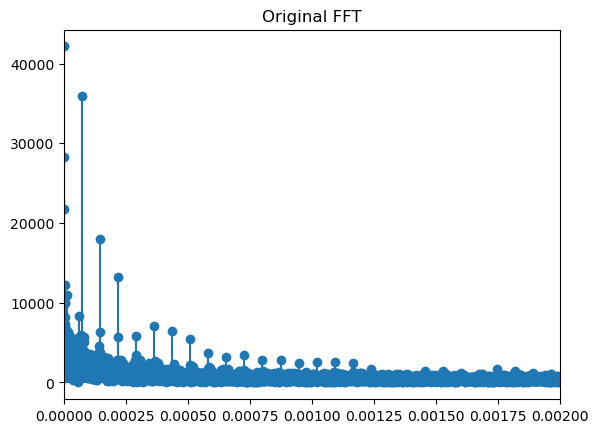

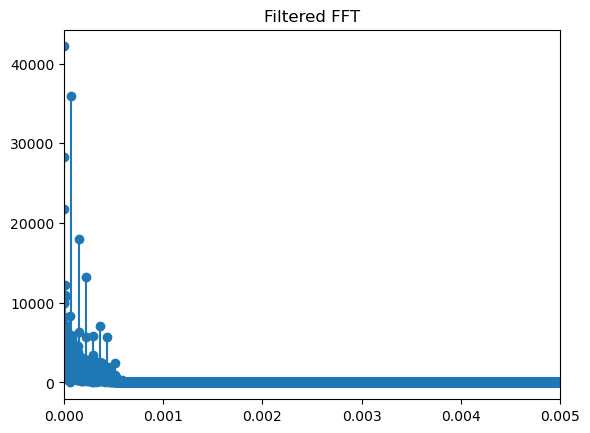

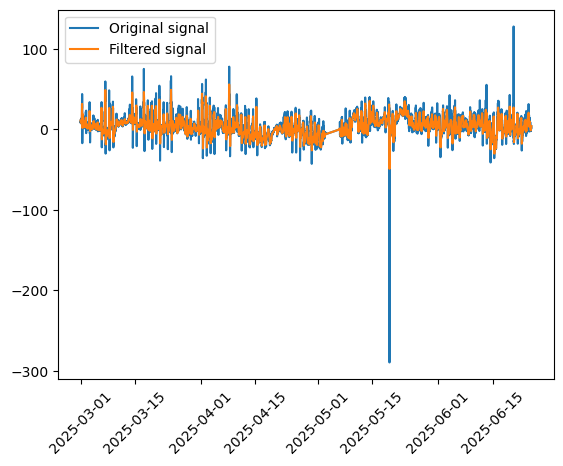

In [2]:
import scipy

dates = data.index

array = data.to_numpy().flatten()
fs = 1/(15*60)
N = len(array)
n = np.arange(N)

Y = np.fft.fft(array)

plt.figure(0)
plt.stem(2*np.pi*fs*n/N,np.abs(Y),basefmt="")
plt.xlim(0,0.002)
plt.title("Original FFT")

cutoff = 0.0005
Wn = cutoff/(2*np.pi)/(fs/2)

b, a = scipy.signal.butter(7,Wn,btype='low')

yf = scipy.signal.filtfilt(b, a, array)

YF = np.fft.fft(yf)

plt.figure(1)
plt.stem(2*np.pi*fs*n/N,np.abs(YF),basefmt="")
plt.xlim(0,0.005)
plt.title("Filtered FFT")

plt.figure(2)
plt.plot(dates, array, label="Original signal")
plt.plot(dates, yf, label="Filtered signal")
plt.xticks(rotation=45)
plt.legend()

# Trying out Welch's method

(0.0, 0.001)

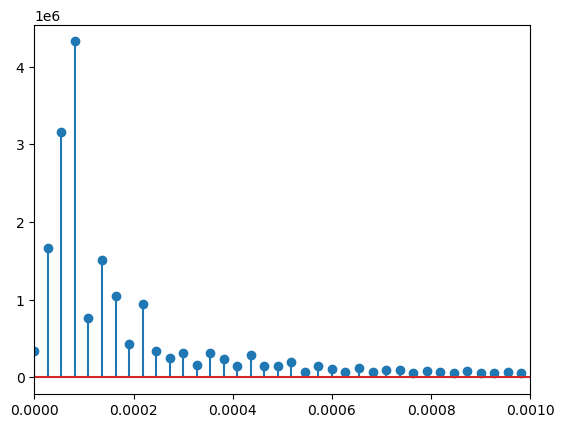

In [3]:
from scipy.signal import welch

f, psd = welch(array, fs, window='hamming', nperseg=256, noverlap=128)
plt.stem(f*2*np.pi,psd)
plt.xlim(0,0.001)

# Noise is a bit clearer to see at around 0.0003 rad/s

## Calculating SNR

In [4]:
noise = array - yf
snr = 10*np.log10(np.sum(yf**2)/np.sum(noise**2))
print(snr) 

7.706145615144843


## Trying out new function

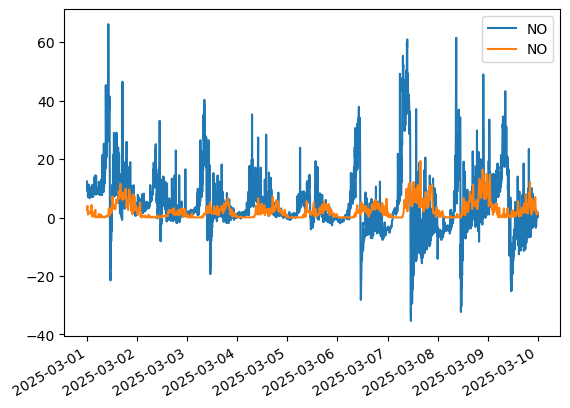

<Figure size 640x480 with 0 Axes>

c:\Users\turev\Documents\Sensorbee\gas_summer_new\gasSommar2\utils_new.py:29: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df2_resampled = df2_resampled.interpolate()


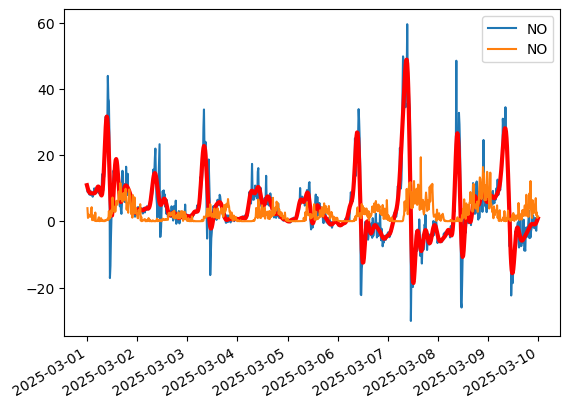

In [5]:
from utils_new import lp_filter
import API_tools as api
import load_data as ld
import unit_conversion as uc
from datetime import datetime as dt
import matplotlib.pyplot as plt
import functions.data_processing as dp
import utils_new as u
import pandas as pd

sensor = api.load_csv("linkoping2_NO.csv")
ref, ref_units = ld.load_slb_data("data/refdata/linkoping-kvartar")

for gas in ["NO","NO2","O3","CO"]:
    ref, ref_units = uc.df_ugm3_to_ppb(ref,ref_units,"NO")

start = dt(2025,3,1)
end = dt(2025,3,10)

sensor_test = sensor[start:end]
ref = ref[start:end]
sensor_test["NO"].plot(legend="Raw signal")
ref["NO"].plot(legend="Reference signal")
plt.figure(0)
plt.show()

sensor_test = sensor_test["NO"]
sensor_test, ref = u.align_and_resample(sensor_test, ref, '15min')

dates, filtered_signal = lp_filter(sensor_test, 15, 0.0005)

plt.figure(1)
plt.plot(dates, filtered_signal, color='red', linewidth=3,zorder=2)
sensor_test.plot(legend="Raw signal",zorder=1)
ref["NO"].plot(legend="Reference signal")
plt.legend()

## Trying out Hampel filtering

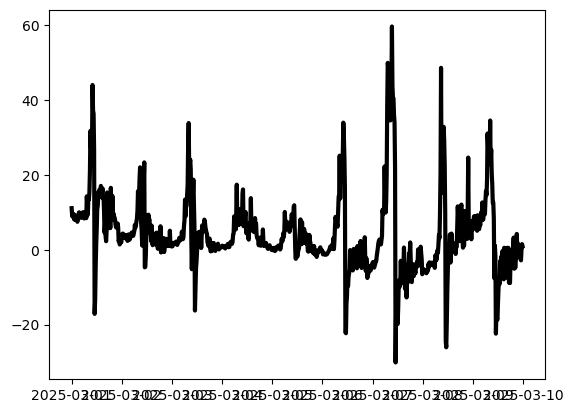

In [ ]:
dates = sensor_test.index
data = sensor_test.to_numpy()

hamp_data = u.hampel_filter(data, 10, 0.01)

plt.plot(dates, hamp_data, color='black', linewidth=3, zorder=2)
plt.plot(dates, sensor_test.to_numpy(), linewidth=1, zorder=1)